# **Development of StarNet**
<div class="alert alert-block alert-info">
<b>Preamble:</b> In fulfiment of Part I of the project, we develop StarNet: a supervised convolutional neural network model that can predict stellar labels. The model is trained and applied separately to synthetic JWST stellar spectra and real APOGEE data, in both cases predicting stellar labels with excellent precision and accuracy.
</div>

## **Table of Contents**
* ### [0. Set Up](#set-up) ###
* ### [1. Process Data](#process-data) ###
  * #### [1.1. Load Data](#load-data) ####
  * #### [1.2. Prepare Data](#prep-data) ####
  * #### [1.3. Emulate Real Data](#emulate-real) ####
  * #### [1.4. Partition Data](#partition-data) ####
* ### [2. Build Model](#build-model) ###
  * #### [2.1. Set up](#set-up-model) ####
  * #### [2.2. Create CNN](#create-CNN) ####
* ### [3. Train Model](#train-model) ###
  * #### [3.1. Set up](#set-up-train) ####
  * #### [3.2. Run training](#run-train) ####
  * #### [3.3. Plot losses & save models](#plot-save) #### 
* ### [4. Test Model](#test-model) ###
  * #### [4.1. Get test predictions](#get-test-preds) ####
  * #### [4.2. Plot residuals](#plot-residuals) ####
  * #### [4.3. Get metrics](#get-metrics) ####
* ### [5. Appendix](#appendix) ###
* ### [6. References](#refs) ###

## **0. Set Up** <a class="anchor" id="set-up"></a>

In [1]:
## Import packages ##
# Standard library
import os
import random
import time
import warnings
from collections import Counter, defaultdict
from pathlib import Path

# Numerical and data analysis
import numpy as np
import pandas as pd

# Visualization
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D

# Signal processing and astronomy
import cv2
import scipy.stats as stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import convolve, fftconvolve
from scipy.special import erf
from scipy.spatial.distance import pdist, squareform
from astropy import constants, units
from astropy.io import fits

# Machine learning and data processing
import umap
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, ElasticNetCV, LinearRegression, Ridge, LassoCV, MultiTaskLasso, MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor 

# PyTorch and Lightning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler 
import torch.autograd as autograd
from torchvision.transforms import Compose
from torch.utils.data import (ConcatDataset, DataLoader, Dataset, RandomSampler, 
                              Subset, TensorDataset)
from torchsummary import summary

# HDF5 and progress bar
import h5py
from tqdm import tqdm

2024-12-11 10:54:57.778701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-11 10:54:59.823559: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Get the number of CPU cores available
num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")

Number of CPU cores: 72


In [3]:
## Set parameters for plotting ## 
plt.rcParams.update({
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.color': 'gray',
    'grid.alpha': 0.4,
    'text.usetex': True,
    'font.family': 'serif'
})

# Set color map
cmap = sns.cubehelix_palette(8, start=2.8, rot=0.1, dark=0, light=0.95, as_cmap=True)

# Set label names
label_names = [
    r'$T_{\mathrm{eff}}$', r'$\log(g)$', r'$C$', r'$N$', r'$O$', r'$Na$', r'$Mg$', r'$Al$', r'$Si$', 
    r'$S$', r'$K$', r'$Ca$', r'$Ti$', r'$V$', r'$Cr$', r'$Mn$', r'$Fe$', r'$Co$', r'$Ni$', r'$Ce$'
]

In [4]:
## Set up seed for reproducibility ## 
def set_seed(seed):
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed) 

## **1. Process Data** <a class="anchor" id="process-data"></a>

### **1.1. Load Data** <a class="anchor" id="load-data"></a>

In [5]:
## Define directories ## 
DATA_DIR = Path('/yngve_data/')
LOCAL_DATA_DIR = Path('/geir_data/scr/sandford')

In [6]:
## Load in JWST files ## 
jwst_spec_file = LOCAL_DATA_DIR / 'JWST_APOGEE.h5'
jwst_wave = pd.read_hdf(jwst_spec_file, 'wavelength').iloc[0].values
jwst_labels = pd.read_hdf(jwst_spec_file, 'labels')
jwst_spectra = pd.read_hdf(jwst_spec_file, 'spectra')

In [7]:
## Load in APOGEE files ## 
apogee_spec_file = LOCAL_DATA_DIR / 'apogee_dr17.h5'
apogee_dr17_dir = DATA_DIR / 'sdss/apogee/dr17/apogee/spectro/aspcap/dr17/synspec'

_LOG10LAMBDA0 = 4.179
_DLOG10LAMBDA = 6. * 10.**-6.
_NLAMBDA = 8575
apogee_wave = 10.**np.arange(
    _LOG10LAMBDA0,
    _LOG10LAMBDA0 +_NLAMBDA * _DLOG10LAMBDA,
    _DLOG10LAMBDA
)
apogee_labels = pd.read_hdf(apogee_spec_file, 'allstar')

### **1.2. Prepare Data** <a class="anchor" id="prep-data"></a>

In [8]:
## Convert JWST row names from stellar tags to indices ## 
jwst_spectra.reset_index(drop=True, inplace=True)
jwst_labels.reset_index(drop=True, inplace=True) 

print(jwst_labels.index) # preview 

RangeIndex(start=0, stop=19799, step=1)


In [9]:
## Drop missing data point in APOGEE data with no JWST pair ## 
apogee_labels.drop(index=11215, inplace=True)
apogee_labels.reset_index(drop=True, inplace=True)

print(apogee_labels.index)
print(f"Shapes of JWST and APOGEE labels before dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

## Drop all duplicates in APOGEE and JWST data ## 
duplicate_indices = apogee_labels[apogee_labels.duplicated(subset='APOGEE_ID', keep='first')].index
apogee_labels.drop(index=duplicate_indices, inplace=True)
jwst_spectra.drop(index=duplicate_indices, inplace=True) 
jwst_labels.drop(index=duplicate_indices, inplace=True)

apogee_labels.reset_index(drop=True, inplace=True)
jwst_spectra.reset_index(drop=True, inplace=True) 
jwst_labels.reset_index(drop=True, inplace=True)

print(f"Shapes of JWST and APOGEE labels after dropping duplicates: {jwst_labels.shape}, {apogee_labels.shape}")

## Calculte bounds for SNR ##
apogee_labels["SNR"].min(), apogee_labels["SNR"].max()

RangeIndex(start=0, stop=19799, step=1)
Shapes of JWST and APOGEE labels before dropping duplicates: (19799, 20), (19799, 55)
Shapes of JWST and APOGEE labels after dropping duplicates: (19001, 20), (19001, 55)


(200.00645446777344, 2943.144775390625)

In [10]:
## Get APOGEE spectra data ## 
#start_time = time.time() 
#apogee_spectra = [] 
#for i in apogee_labels.index: 
   # telescope = apogee_labels.loc[i, 'TELESCOPE'].decode("utf-8")
   # field = apogee_labels.loc[i, 'FIELD'].decode("utf-8")
   # file = apogee_labels.loc[i, 'FILE'].decode("utf-8")
   # file = f"aspcapStar-dr17-{apogee_labels.loc[i, 'APOGEE_ID'].decode('utf-8')}.fits"
   # path_to_spec = apogee_dr17_dir / telescope / field / file
   # hdul = fits.open(path_to_spec)
   # apogee_spec = hdul[1].data.astype(float)
   # apogee_spectra.append(apogee_spec)
   # hdul.close()
#end_time = time.time()

## Print elapsed time ##
#print(f"Elapsed time to download APOGEE spectra: {end_time - start_time:.2f} seconds")

## Save APOGEE spectra data as pickled file ## 
#apogee_spectra = pd.DataFrame(apogee_spectra)
#apogee_spectra.columns = apogee_wave 
#apogee_spectra.to_pickle(os.path.join("DATA", "apogee_spectra.pkl"))

## Download APOGEE spectra data ## 
apogee_spectra = pd.read_pickle(os.path.join("DATA", "apogee_spectra.pkl"))

## Print out shapes of APOGEE and JWST spectra data ##
print(f"Shape of APOGEE and JWST spectra: {apogee_spectra.shape}, {jwst_spectra.shape}")

Shape of APOGEE and JWST spectra: (19001, 8575), (19001, 8192)


In [11]:
## Make noisy JWST data using saved APOGEE SNR  ## 
noise_to_signal = np.array((apogee_labels["SNR"])**(-1)) 
noise_to_signal_values = noise_to_signal.copy()
noise_to_signal = noise_to_signal[:, np.newaxis] 
noise_to_signal = np.tile(noise_to_signal, (1, 8192))
noisy_jwst_spectra = jwst_spectra + np.random.normal(0, 10*jwst_spectra.values*noise_to_signal) 

## Drop unneeded APOGEE labels ## 
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_FE', '').capitalize())
apogee_labels = apogee_labels.iloc[:, 9:]  # drop first nine columns
apogee_labels = apogee_labels.loc[:, ~apogee_labels.columns.str.endswith('err')]
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('Logg', 'logg'))
apogee_labels = apogee_labels.drop(columns=["M_h", "Alpha_m", "Vmicro", "Vmacro"])
apogee_labels = apogee_labels.rename(columns=lambda x: x.replace('_h', ''))

## Rescale Teff ## 
apogee_labels["Teff"] = apogee_labels["Teff"]/1000 
jwst_labels["Teff"] = jwst_labels["Teff"]/1000 

In [12]:
## Convert APOGEE metallicities [X/Fe] to JWST metallicities [X/H] ## 
# Note: [X/Fe] + [Fe/H] = [X/H].
Fe_H = apogee_labels["Fe"]
for i in range(2, len(apogee_labels.columns)):
    if i != apogee_labels.columns.get_loc('Fe'): # Fe column is already of the form [Fe/H] 
        apogee_labels.iloc[:, i] += Fe_H

## Check! ## 
all(jwst_labels == apogee_labels) == True

True

### **1.3. Emulate Real Data** <a class="anchor" id="prep-data"></a>

#### **1.3.1. Extract Gaps KDE** <a class="anchor" id="extract-gaps"></a>

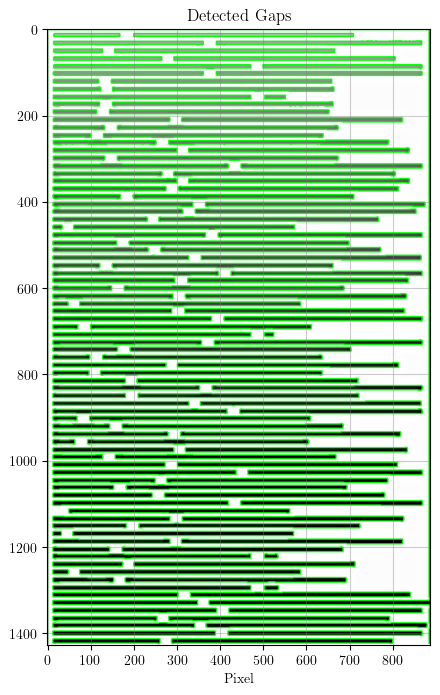

In [13]:
## Detect and Process Gaps in Spectral Data Image ##
# Load the image
image_path = os.path.join("FIGURES", "Sample_Real_Data.png")
image = cv2.imread(image_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding to distinguish the gaps
_, binary_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)

# Find contours, which correspond to the gaps
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image (for visualization)
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)

# Initialize a dictionary to store gaps grouped by y-coordinate
blocks_by_y = defaultdict(list)

# Measure the bounding box of each contour and group by y-coordinate
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if y != 0:  # Exclude contours at the top edge
        blocks_by_y[y].append((x, w))

# Initialize lists to store (x, w) of gaps
x_gaps1 = []
x_gaps2 = []
w_gaps1 = []
w_gaps2 = []

# Process grouped gaps
for y_coord, blocks in blocks_by_y.items():
    if len(blocks) == 2:
        # Sort blocks by x-coordinate
        blocks.sort(key=lambda block: block[0])
        
        # Calculate x and width of first and second gaps
        x_gap1 = blocks[0][0] + blocks[0][1]
        w_gap1 = blocks[1][0] - x_gap1
        x_gap2 = blocks[1][0] + blocks[1][1]
        w_gap2 = 888 - x_gap2
        
        # Append results to the lists
        x_gaps1.append(x_gap1)
        x_gaps2.append(x_gap2)
        w_gaps1.append(w_gap1)
        w_gaps2.append(w_gap2)

# Convert pixel values to wavelength scale (in micrometers)
conversion_factor = (1.8 - 0.95) * 10**4 / 888
x_gaps1 = [x * conversion_factor + 0.95 * 10**4 for x in x_gaps1]
w_gaps1 = [w * conversion_factor for w in w_gaps1]
w_gaps2 = [w * conversion_factor for w in w_gaps2]

# Display the original image with contours
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Detected Gaps")
plt.xlabel("Pixel")
plt.show()

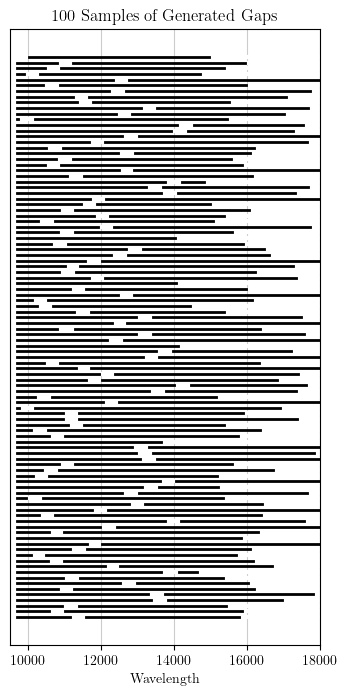

In [14]:
## Extract KDE to Generate New Gaps ##
set_seed(42)
kde_x_gaps1 = stats.gaussian_kde(x_gaps1)
kde_w_gaps1 = stats.gaussian_kde(w_gaps1)
kde_w_gaps2 = stats.gaussian_kde(w_gaps2)

# Resample from KDE ensuring non-negative values
def resample_non_negative(kde, size):
    set_seed(42)  # Ensure reproducibility
    samples = kde.resample(size)
    return np.maximum(samples, 0).squeeze()

# Generate new gaps
n = jwst_spectra.shape[0]  # Total number of samples
new_x_gaps1 = resample_non_negative(kde_x_gaps1, n)
new_w_gaps1 = resample_non_negative(kde_w_gaps1, n)
new_w_gaps2 = resample_non_negative(kde_w_gaps2, n)

# Visualize a sample of the gaps created
plt.figure(figsize=(4, 8))
for i in range(100):
    x = np.linspace(0.97 * 10**4, 1.8 * 10**4, 100)
    y = np.ones_like(x) + i
    plt.plot(x, y, 'k-', linewidth=2)

    plt.plot([new_x_gaps1[i], new_x_gaps1[i] + new_w_gaps1[i]], [y[0], y[0]], 'w-', linewidth=3)
    plt.plot([1.8 * 10**4 - new_w_gaps2[i], 1.8 * 10**4], [y[0], y[0]], 'w-', linewidth=3)

plt.xlim([0.95 * 10**4, 1.8 * 10**4])
plt.tick_params(left=False)
plt.yticks([])
plt.xlabel("Wavelength")
plt.title("100 Samples of Generated Gaps")
plt.show()

In [15]:
def add_noise_to_spectra(jwst_spectra, snr_min=30, snr_max=300):
    """
    Add noise to all spectra in the DataFrame using a randomly chosen 
    SNR from a specified range.

    Parameters:
    - jwst_spectra (DataFrame): The DataFrame containing spectra data.
    - snr_min (int): Minimum SNR value.
    - snr_max (int): Maximum SNR value.

    Returns:
    - DataFrame: Noisy jwst_spectra with added noise.
    """
    # Copy the input DataFrame to avoid modifying the original
    noisy_spectra = jwst_spectra.copy()

    # Iterate through all rows in the DataFrame
    for idx in noisy_spectra.index:
        # Extract the spectrum for the current index
        spectrum = noisy_spectra.loc[idx].values

        # Sample SNR from a uniform distribution
        snr = np.random.uniform(snr_min, snr_max)

        # Calculate the noise standard deviation based on the SNR
        noise_std = 1 / snr ** 0.5

        # Add Gaussian noise to the spectrum
        noisy_spectra.loc[idx] = spectrum + np.random.normal(0, noise_std, size=spectrum.shape)

    return noisy_spectra

mock_jwst_spectra = add_noise_to_spectra(jwst_spectra)

In [16]:
def blank_out_ranges(jwst_spectra, x_gaps1, w_gaps1, w_gaps2):
    """
    Blanks out specified ranges in the JWST spectra by setting values to 1 within the defined gaps.

    Parameters:
    - jwst_spectra (pd.DataFrame): A DataFrame containing JWST spectra, with rows as samples and columns as wavelengths.
    - x_gaps1 (list): Starting positions for the gaps in the spectra.
    - w_gaps1 (list): Widths of the gaps starting from x_gaps1.
    - w_gaps2 (list): Widths of the gaps at the end of the spectra.
    
    Returns:
    - pd.DataFrame: A modified copy of the JWST spectra with specified ranges blanked out (set to 1).
    """
    # Create a copy of the input DataFrame to avoid modifying the original
    modified_spectra = jwst_spectra.copy()

    # Convert column names to numeric values for comparison
    wavelengths = jwst_spectra.columns.astype(float)

    # Loop through each spectrum and apply the blanking
    for i, (start1, width1, width2) in enumerate(zip(x_gaps1, w_gaps1, w_gaps2)):
        # Define gap positions
        end1 = start1 + width1
        start2 = wavelengths.max() - width2
        end2 = wavelengths.max()

        # Create boolean masks for the gaps
        mask1 = (wavelengths >= start1) & (wavelengths <= end1)
        mask2 = (wavelengths >= start2) & (wavelengths <= end2)
        combined_mask = mask1 | mask2

        # Apply the masks to the current spectrum
        modified_spectra.iloc[i, combined_mask] = 1

    return modified_spectra

In [17]:
mock_jwst_spectra = blank_out_ranges(mock_jwst_spectra, new_x_gaps1, new_w_gaps1, new_w_gaps2)

### **1.4. Partition Data** <a class="anchor" id="partition-data"></a>

In [18]:
## Standardise data ## 
scaler = StandardScaler()
jwst_labels_scaled = pd.DataFrame(scaler.fit_transform(jwst_labels), columns = jwst_labels.columns)
apogee_labels_scaled = pd.DataFrame(scaler.fit_transform(apogee_labels), columns = apogee_labels.columns)

## Check! ##
print(all(abs(jwst_labels_scaled - apogee_labels_scaled) < 1e-6))

## Define denormalising function to undo StandardScaler ## 
def denormalize(scaler, labels_scaled):
    """
    Denormalises data scaled with StandardScaler. 

    Parameters:
    - scaler (StandardScaler): used to scale the data.
    - labels_scaled (pd.DataFrame): scaled data to be denormalised.

    Returns:
    - pd.DataFrame: data transformed back to its original scale. 
    """
    mean = scaler.mean_ 
    std = scaler.scale_
    return (labels_scaled * std) + mean

True


In [19]:
## Define inputs and outputs ##
X_j = mock_jwst_spectra.values
X_a = apogee_spectra.values

y_j = jwst_labels_scaled.values
y_a = apogee_labels_scaled.values

## Print shapes ##
print(f"Shapes of JWST inputs and outputs: {X_j.shape}, {y_j.shape}")
print(f"Shapes of APOGEE inputs and outputs: {X_a.shape}, {y_a.shape}")

Shapes of JWST inputs and outputs: (19001, 8192), (19001, 20)
Shapes of APOGEE inputs and outputs: (19001, 8575), (19001, 20)


In [20]:
## Create function to partition data into train, val and test sets ## 
def train_val_test_split(X, y): 
    """
    Partitions data into training, validation, and test sets with a 5:1:2 ratio. 
    This function ensures reproducibility by setting a random seed.

    Parameters:
    - X (pd.DataFrame): Feature matrix.
    - y (pd.DataFrame): Target matrix.

    Returns:
    - X_train (pd.DataFrame): Training feature matrix.
    - X_val (pd.DataFrame): Validation feature matrix.
    - X_test (pd.DataFrame): Test feature matrix.
    - y_train (pd.DataFrame): Training target matrix.
    - y_val (pd.DataFrame): Validation target matrix.
    - y_test (pd.DataFrame): Test target matrix.
    """
    # First, split data into 75% train and 25% test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/4, random_state = 42) 
    # Next, split train into 5/6 train and 1/6 validation 
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/6, random_state = 42) 
    return X_train, X_val, X_test, y_train, y_val, y_test 

## Partition data ## 
X_j_train, X_j_val, X_j_test, y_j_train, y_j_val, y_j_test = train_val_test_split(X_j, y_j) 
X_a_train, X_a_val, X_a_test, y_a_train, y_a_val, y_a_test = train_val_test_split(X_a, y_a) 

print(f"Shapes of JWST train, val, test sets: {X_j_train.shape}, {X_j_val.shape}, {X_j_test.shape}")
print(f"Shapes of APOGEE train, val, test sets: {X_a_train.shape}, {X_a_val.shape}, {X_a_test.shape}")

Shapes of JWST train, val, test sets: (11875, 8192), (2375, 8192), (4751, 8192)
Shapes of APOGEE train, val, test sets: (11875, 8575), (2375, 8575), (4751, 8575)


## **2. Build Model** <a class="anchor" id="build-model"></a>

### **2.1. Set up** <a class="anchor" id="set-up-model"></a>

In [21]:
## Define helper function ## 
def compute_out_size(in_size, mod):
    """
    Compute the output size of a PyTorch module `mod` given an input with size `in_size`.

    Args:
        in_size (tuple): The size of the input tensor (excluding batch size).
        mod (torch.nn.Module): The PyTorch module for which to compute the output size.

    Returns:
        tuple: The size of the output tensor (excluding batch size).
    """
    
    f = mod.forward(autograd.Variable(torch.Tensor(1, *in_size)))
    return f.size()[1:]

In [22]:
## Instantiate neural network parameters ## 
num_filters = [4, 16] # Number of filters used in convolutional layers
filter_length = 8 # Length of the filters in convolutional layers
pool_length = 4 # Length of maxpooling window 
num_hidden = [256, 128] # Number of nodes in each of hidden fully connected layers

num_jwst_labels = y_j_train.shape[1] # Number of JWST labels  
num_apogee_labels = y_a_train.shape[1] # Number of APOGEE labels 

num_jwst_fluxes = X_j_train.shape[1] # Number of JWST fluxes
num_apogee_fluxes = X_a_train.shape[1] # Number of APOGEE fluxes

### **2.2. Create CNN** <a class="anchor" id="create-CNN"></a>

In [23]:
## Define CNN ## 
class StarNet(nn.Module):
    def __init__(self, num_fluxes: int, num_filters: list, filter_length: int, pool_length: int, num_hidden: list, num_labels: int):
        super(StarNet, self).__init__()
        # Define convolutional layers 
        self.conv1 = nn.Conv1d(in_channels = 1, out_channels = num_filters[0], kernel_size = filter_length)
        self.conv2 = nn.Conv1d(in_channels = num_filters[0], out_channels = num_filters[1], kernel_size = filter_length)

        # Define pooling layer 
        self.pool = nn.MaxPool1d(pool_length, pool_length)

        # Compute shape after pooling
        pool_output_shape = compute_out_size((1,num_fluxes), nn.Sequential(self.conv1, self.conv2, self.pool))
        
        # Define fully connected layers
        self.fc1 = nn.Linear(in_features = pool_output_shape[0]*pool_output_shape[1], out_features = num_hidden[0])
        self.fc2 = nn.Linear(in_features = num_hidden[0], out_features = num_hidden[1])
        self.output = nn.Linear(in_features = num_hidden[1], out_features = num_labels)
    
    def forward(self, x):
        x = F.elu(self.conv1(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = torch.flatten(x, start_dim = 1)
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.output(x)
        return x

In [24]:
## Instantiate CNN ## 
torch.manual_seed(42) # for reproducibility
APOGEEModel = StarNet(num_apogee_fluxes, num_filters, filter_length, pool_length, num_hidden, num_apogee_labels)
JWSTModel = StarNet(num_jwst_fluxes, num_filters, filter_length, pool_length, num_hidden, num_jwst_labels)

## Move models to GPU ## 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"Device is {device}")
APOGEEModel.to(device); JWSTModel.to(device)

Device is cuda


StarNet(
  (conv1): Conv1d(1, 4, kernel_size=(8,), stride=(1,))
  (conv2): Conv1d(4, 16, kernel_size=(8,), stride=(1,))
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=32704, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=20, bias=True)
)

In [25]:
## Summarise CNN ## 
summary(APOGEEModel, (1, num_apogee_fluxes)) # JWST model is similar 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 8568]              36
            Conv1d-2             [-1, 16, 8561]             528
         MaxPool1d-3             [-1, 16, 2140]               0
            Linear-4                  [-1, 256]       8,765,696
            Linear-5                  [-1, 128]          32,896
            Linear-6                   [-1, 20]           2,580
Total params: 8,801,736
Trainable params: 8,801,736
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 1.57
Params size (MB): 33.58
Estimated Total Size (MB): 35.18
----------------------------------------------------------------


## **3. Train Model** <a class="anchor" id="train-model"></a>

### **3.1. Set up** <a class="anchor" id="set-up-train"></a>

In [26]:
## Instantiate training parameters ## 
batch_size = 64 # Number of rows processed in one iteration of training (before updating its parameters) 
batch_size_val = 300 
batch_size_test = 500 
num_epochs = 15 # Number of epochs- number of complete passes through entire training dataset.  
learning_rate = 0.001 # Initial learning rate parameter for optimisation algorithm 

## Construct optimiser ## 
APOGEEOptimizer = torch.optim.Adam(APOGEEModel.parameters(), learning_rate, weight_decay = 0) 
JWSTOptimizer = torch.optim.Adam(JWSTModel.parameters(), learning_rate, weight_decay = 0)

## Implement learning rate scheduler ## 
APOGEEScheduler = lr_scheduler.StepLR(APOGEEOptimizer, step_size = 5, gamma = 0.1)
JWSTScheduler = lr_scheduler.StepLR(JWSTOptimizer, step_size = 5, gamma = 0.1) 

In [27]:
## Define function to create dataloaders ## 
def create_dataloader(X, y, batch_size, shuffle=True):
    """
    Creates a PyTorch DataLoader from input features and labels.
    
    Args:
    - X (array-like): The input features. 
    - y (array-like): The corresponding labels or target values. 
    - batch_size (int): The number of samples per batch to load.
    - shuffle (bool, optional): Whether to shuffle the data at every epoch. Default is True.

    Returns:
    - DataLoader: A DataLoader object that can be used to iterate over the dataset in batches.
    """ 
    tensor_data = TensorDataset(torch.Tensor(X), torch.Tensor(y))
    return DataLoader(tensor_data, batch_size=batch_size, shuffle=shuffle)

random.seed(42) # for reproducibility 

## Convert train, val, test datasets to dataloaders ## 
train_j_dataloader = create_dataloader(X_j_train, y_j_train, batch_size)
train_a_dataloader = create_dataloader(X_a_train, y_a_train, batch_size)

val_j_dataloader = create_dataloader(X_j_val, y_j_val, batch_size_val, shuffle=False)
val_a_dataloader = create_dataloader(X_a_val, y_a_val, batch_size_val, shuffle=False)

test_j_dataloader = create_dataloader(X_j_test, y_j_test, batch_size_test, shuffle=False)
test_a_dataloader = create_dataloader(X_a_test, y_a_test, batch_size_test, shuffle=False)

### **3.2. Run training** <a class="anchor" id="run-train"></a>

In [28]:
## Define function to execute training ## 
def train_model(train_dataloader, val_dataloader, model, optimizer, scheduler, model_name):
    """
    Trains a PyTorch model using a specified optimiser, learning rate scheduler and dataloaders for a given number of epochs, using MSE Loss.
    Evaluates the model on a validation set after each epoch, using MSE Loss. 

    Parameters:
    - train_dataloader (DataLoader): DataLoader for training data.
    - val_dataloader (DataLoader): DataLoader for validation data.
    - model (torch.nn.Module): PyTorch model to be trained. 
    - scheduler (torch.optim.lr_scheduler._LRScheduler): learning rate scheduler to adjust learning rate. 
    - optimizer (torch.optim.Optimizer): optimiser used to update model parameters.
    - model_name (str): 'APOGEE' or 'JWST'. 

    Returns: 
    - train_losses (list): A list of average training losses for each epoch.
    - val_losses (list): A list of average validation losses for each epoch. 
    """
    train_losses = []
    val_losses = []

    print(f"Begin training {model_name}") 

    for epoch in range(num_epochs):
        running_train_loss = 0.0
        
        # Training Loop
        for i, (X_batch, y_batch) in enumerate(train_dataloader):
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(X_batch.unsqueeze(1).to(device))
            loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_train_loss += loss.item()

            # Print statistics every 'print_iters' iterations
            if (i + 1) % print_iters == 0:
                print(f'[Epoch {epoch + 1}, {(i + 1) / len(train_dataloader) * 100:.0f}%] '
                      f'Train Loss: {running_train_loss / (i + 1):.4f}', end="\r")
        
        train_loss = running_train_loss / len(train_dataloader)

        # Validation Loop
        running_val_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in val_dataloader:
                y_pred = model(X_batch.unsqueeze(1).to(device))
                loss = nn.MSELoss()(y_pred.to(device), y_batch.to(device))
                running_val_loss += loss.item()
        
        val_loss = running_val_loss / len(val_dataloader)
        
        # Print epoch summary
        print(f'[Epoch {epoch + 1}] Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
              f'LR: {scheduler.get_last_lr()[0]:.6f}')
        
        # Record losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Step the scheduler
        scheduler.step()
    
    print("Finished Training \n")
    return train_losses, val_losses

print_iters = 200
train_j_losses, val_j_losses = train_model(train_j_dataloader, val_j_dataloader, JWSTModel, JWSTOptimizer, JWSTScheduler, "JWST")
train_a_losses, val_a_losses = train_model(train_a_dataloader, val_a_dataloader, APOGEEModel, APOGEEOptimizer, APOGEEScheduler, "APOGEE")

Begin training JWST
[Epoch 1] Train Loss: 1.0357, Val Loss: 0.8573, LR: 0.001000
[Epoch 2] Train Loss: 0.4856, Val Loss: 0.3073, LR: 0.001000
[Epoch 3] Train Loss: 0.2716, Val Loss: 0.2627, LR: 0.001000
[Epoch 4] Train Loss: 0.1843, Val Loss: 0.2545, LR: 0.001000
[Epoch 5] Train Loss: 0.1314, Val Loss: 0.1943, LR: 0.001000
[Epoch 6] Train Loss: 0.0873, Val Loss: 0.1883, LR: 0.000100
[Epoch 7] Train Loss: 0.0820, Val Loss: 0.1889, LR: 0.000100
[Epoch 8] Train Loss: 0.0789, Val Loss: 0.1859, LR: 0.000100
[Epoch 9] Train Loss: 0.0754, Val Loss: 0.1887, LR: 0.000100
[Epoch 10] Train Loss: 0.0724, Val Loss: 0.1854, LR: 0.000100
[Epoch 11] Train Loss: 0.0681, Val Loss: 0.1849, LR: 0.000010
[Epoch 12] Train Loss: 0.0676, Val Loss: 0.1849, LR: 0.000010
[Epoch 13] Train Loss: 0.0672, Val Loss: 0.1849, LR: 0.000010
[Epoch 14] Train Loss: 0.0669, Val Loss: 0.1849, LR: 0.000010
[Epoch 15] Train Loss: 0.0665, Val Loss: 0.1846, LR: 0.000010
Finished Training 

Begin training APOGEE
[Epoch 1] Train L

### **3.3. Plot losses & save models** <a class="anchor" id="plot-save"></a>

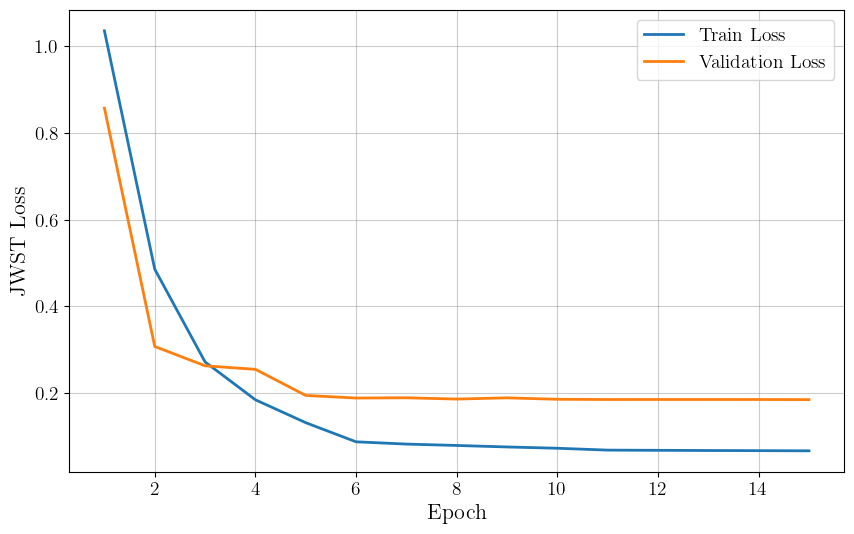

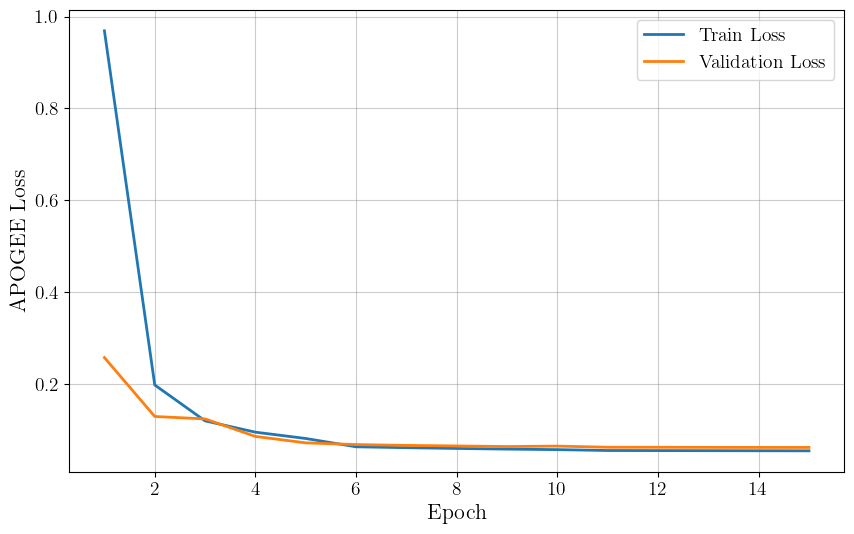

In [29]:
## Plot losses ## 
def plot_losses(train_losses, val_losses, model_name):
    """
    Plots training and validation losses over epochs. Save figure to "FIGURES" directory. 

    Args:
    - train_losses (list): contains training losses for each epoch.
    - val_losses (list): contains validation losses for each epoch.
    - model_name (str): 'APOGEE' or 'JWST'. 
    """
    plt.figure(figsize=(10, 6))  
    plt.plot(range(1, num_epochs + 1), train_losses, label = "Train Loss", linewidth=2)
    plt.plot(range(1, num_epochs + 1), val_losses, label = "Validation Loss", linewidth=2)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel(f"{model_name} Loss", fontsize=16)
    plt.legend(fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14) 
    
    # Save the figure
    plt.savefig(os.path.join("FIGURES", f"StarNet_{model_name}_loss_plot.png"))
    plt.show()
    plt.close()

plot_losses(train_j_losses, val_j_losses, "JWST")
plot_losses(train_a_losses, val_a_losses, "APOGEE")

In [30]:
## Save models ## 
def save_model(model, optimizer, model_name):
    """
    Save model and optimizer states to a specified file path.

    Parameters:
    - model (torch.nn.Module): PyTorch model to be saved.
    - optimizer (torch.optim.Optimizer): PyTorch optimizer to be saved.
    - model_name (str): 'APOGEE' or 'JWST'. 
    """
    torch.save({'optimizer' : optimizer.state_dict(),
                'model' : model.state_dict()}, 
               os.path.join("MODELS", f"StarNet_{model_name}.pth.tar"))
    print(f"Done.")
    
save_model(JWSTModel, JWSTOptimizer, "JWST") 
save_model(APOGEEModel, APOGEEOptimizer, "APOGEE") 

Done.
Done.


## **4. Test Model** <a class="anchor" id="test-model"></a>

### **4.1. Get test predictions** <a class="anchor" id="get-test-preds"></a>

In [33]:
## Get denormalised predictions on test set ## 
def get_test_preds(model, test_dataloader):
    """
    Performs inference on test data and returns denormalized predictions. Requires the denormalize function, defined previously.

    Parameters:
    - model (torch.nn.Module): PyTorch model used for inference.
    - test_dataloader (torch.utils.data.DataLoader): DataLoader for the test set.

    Returns: 
    - test_preds (np.array): denormalized predictions. 
    """
    model.eval()
    test_preds = []
    with torch.inference_mode():
        for x_batch in test_dataloader:
            preds = model(x_batch[0].to(device).unsqueeze(1)).cpu().detach().numpy()
            test_preds.append(denormalize(scaler, preds)) 

    # Concatenate the list of numpy arrays
    return np.concatenate(test_preds)

test_j_preds = get_test_preds(JWSTModel, test_j_dataloader)
test_a_preds = get_test_preds(APOGEEModel, test_a_dataloader)

## Print shape of preds ## 
print(f"Shape of JWST test predictions is {test_j_preds.shape}") 
print(f"Shape of APOGEE test predictions is {test_a_preds.shape}")

Shape of JWST test predictions is (4751, 20)
Shape of APOGEE test predictions is (4751, 20)


### **4.2. Plot residuals** <a class="anchor" id="plot-residuals"></a>

In [34]:
## Get indices of JWST and APOGEE test sets (note: they are the same) ## 
test_indices = [np.where((jwst_labels_scaled.values == y_j_test[i]).all(axis=1))[0][0] for i in range(len(y_j_test))]

In [35]:
## Get residuals ## 
jwst_residuals = denormalize(scaler, y_j_test) - test_j_preds # alternatively, jwst_labels.iloc[test_j_indices] - test_j_preds
apogee_residuals = denormalize(scaler, y_a_test) - test_a_preds 

In [36]:
## Get SNR values ## 
z = np.array((noise_to_signal**(-1))[test_indices]) 

## Truncate SNR at ~90th percentile ## 
z[z > round(np.percentile(z, 90), -2)] = round(np.percentile(z, 90), -2) 

In [37]:
## Re-order SNR and residuals ## 
#order = z.reshape(z.shape[0], ).argsort() 

#z = z[order] 
jwst_true = denormalize(scaler, y_j_test)#[order] 
apogee_true = denormalize(scaler, y_a_test)#[order] 
jwst_residuals = jwst_residuals#[order]
apogee_residuals = apogee_residuals#[order]

## Sort indices according to SNR threshold ## 
indices_a = np.where(z >= round(np.percentile(z, 50), -2)) 
indices_b = np.where(z < round(np.percentile(z, 50), -2))

## Print cut-offs ##
print(f"SNR 50th, 90th percentile: {round(np.percentile(z, 50), -2), round(np.percentile(z, 90), -2)}")

## Filter residuals based on SNR thresholds ## 
#resid_j_a = jwst_residuals[indices_a,:]; resid_j_b = jwst_residuals[indices_b,:] 
#resid_a_a = apogee_residuals[indices_a,:]; resid_a_b = apogee_residuals[indices_b,:]

SNR 50th, 90th percentile: (300.0, 700.0)


In [38]:
## Define bias and scatter ## 
bias_j = np.median(jwst_residuals, axis=0); bias_a = np.median(apogee_residuals, axis = 0)
scatter_j = np.std(jwst_residuals, axis=0); scatter_a = np.std(apogee_residuals, axis = 0)

In [39]:
def plot_residuals(targets, residue, z, resid_a, resid_b, bias, scatter, model_name):
    """
    Plot residuals and their distributions for all labels.
    
    Parameters:
    - targets: Array of true target values.
    - residue: Array of residuals for each label.
    - z: Array of SNR values used for coloring the scatter plots.
    - resid_a: Residuals for SNR values above the threshold.
    - resid_b: Residuals for SNR values below the threshold.
    - bias: List of bias values for each label.
    - scatter: List of scatter values for each label.
    - model_name: 'APOGEE' or 'JWST'.  
    """
    
    num_labels = targets.shape[1]

    # Create a figure with subplots
    fig = plt.figure(figsize=(20, 50))
    gs = gridspec.GridSpec(20, 2, width_ratios=[4., 1.])

    for i in range(num_labels):
        # Scatter plot for residuals
        ax0 = plt.subplot(gs[i, 0])
        points = ax0.scatter(targets[:, i], residue[:, i], c=z, s=20, cmap=cmap)

        ax0.set_xlabel(f'True {label_names[i]}', fontsize=14)
        ax0.set_ylabel(rf'$\Delta$ {label_names[i]}' + f'\n(True - {model_name} Pred)', fontsize=14)
        ax0.tick_params(labelsize=12, width=1, length=5)

        # KDE plot for residual distributions
        ax1 = plt.subplot(gs[i, 1])
        sns.kdeplot(y=resid_a[0, :, i], color=cmap(200), lw=3, ax=ax1, label='SNR $\geq$300')
        sns.kdeplot(y=resid_b[0, :, i], color=cmap(100), lw=3, ax=ax1, label='SNR $<$300')
        if i == 0:
            plt.legend()

        ax1.tick_params(right=True, labelleft=False, labelright=True, labelbottom=False, labelsize=12, width=1, length=5)
        ax1.set_xlabel('')

        # Display bias and scatter values
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=1)
        plt.figtext(0.1, 0.99 - (i*0.05),
                    rf'$\widetilde{{m}}$={bias[i]:.3f}  $s$={scatter[i]:.3f}',
                    size=14, bbox=bbox_props)

    # Add colorbar
    cbar_ax = fig.add_axes([0.9, 0.1, 0.02, 0.83])
    cbar = fig.colorbar(points, cax=cbar_ax)
    cbar.set_label('SNR', size=14)
    cbar.ax.tick_params(labelsize=14, width=1, length=5)
    cbar.set_ticks([200, 300, 400, 500, 600, 700])
    cbar.set_ticklabels(['200', '300', '400', '500', '600', '$>$700'])
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)

    plt.savefig(os.path.join("FIGURES", f"STARNet_{model_name}_residual_plots.png"))
    plt.show()

#plot_residuals(jwst_true, jwst_residuals, z, resid_j_a, resid_j_b, bias_j, scatter_j, "JWST")
#plot_residuals(apogee_true, jwst_residuals, z, resid_j_a, resid_j_b, bias_j, scatter_j, "APOGEE")

### **4.3. Get metrics** <a class="anchor" id="get-metrics"></a>

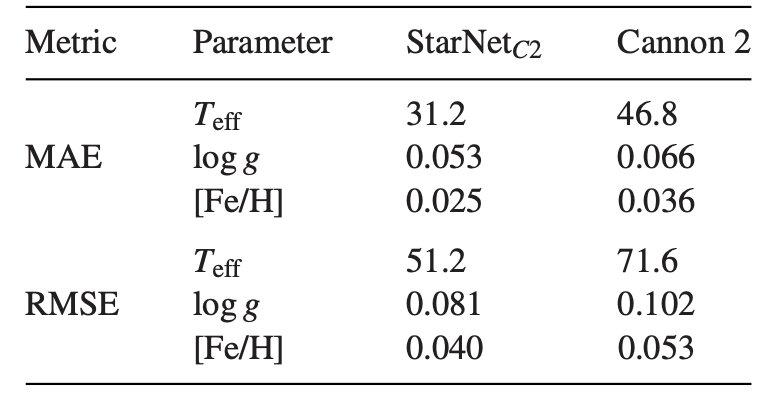 

In [40]:
def get_metrics(targets, test_preds, model_name):
    """
    Calculate evaluation metrics for each label in a set of predictions.

    Parameters:
    - targets (np.array): true target values.
    - test_preds (np.array): predicted test values.
    - model_name (str): 'APOGEE' or 'JWST'. 

    Returns:
    - DataFrame containing MAE, MSE, RMSE for each label, rounded to 3 decimal places. 
    """

    MAE = []
    MSE = []
    RMSE = [] 

    targets = pd.DataFrame(targets) 
    test_preds = pd.DataFrame(test_preds)

    for i in range(test_preds.shape[1]):
        MAE.append(mean_absolute_error(targets[i], test_preds[i]))
        MSE.append(mean_squared_error(targets[i], test_preds[i]))
        RMSE.append(np.sqrt(mean_squared_error(targets[i], test_preds[i]))) 

    metrics = pd.DataFrame({
        f'{model_name} Labels': label_names,
        'MAE': MAE,
        'MSE': MSE,
        'RMSE': RMSE
    }).round(3)

    return metrics 

get_metrics(jwst_true, test_j_preds, "JWST")

,JWST Labels,MAE,MSE,RMSE
0,$T_{\mathrm{eff}}$,0.055,0.005,0.073
1,$\log(g)$,0.141,0.033,0.182
2,$C$,0.109,0.021,0.147
3,$N$,0.070,0.009,0.097
4,$O$,0.087,0.013,0.115
5,$Na$,0.110,0.023,0.153
6,$Mg$,0.089,0.014,0.118
7,$Al$,0.101,0.019,0.138
8,$Si$,0.082,0.012,0.107
9,$S$,0.085,0.013,0.112


In [41]:
get_metrics(apogee_true, test_a_preds, "APOGEE")

,APOGEE Labels,MAE,MSE,RMSE
0,$T_{\mathrm{eff}}$,0.019,0.001,0.027
1,$\log(g)$,0.064,0.007,0.086
2,$C$,0.052,0.006,0.076
3,$N$,0.050,0.007,0.082
4,$O$,0.038,0.003,0.053
5,$Na$,0.082,0.015,0.124
6,$Mg$,0.041,0.003,0.057
7,$Al$,0.051,0.007,0.081
8,$Si$,0.035,0.002,0.050
9,$S$,0.055,0.006,0.076


## **5. Appendix** <a class="anchor" id="appendix"></a>
OLD VERSIONS OF NOTEBOOK AVAILABLE IN `/SCRATCH/OLD_NOTEBOOKS`:
- `JWSTNet.ipynb`
- `APOGEENet.ipynb` 

## **6. References** <a class="anchor" id="refs"></a>
**Literature** 
Fabbro, S., “An application of deep learning in the analysis of stellar spectra”, <i>Monthly Notices of the Royal Astronomical Society</i>, vol. 475, no. 3, OUP, pp. 2978–2993, 2018. doi:10.1093/mnras/stx3298.

**Code** 
https://github.com/astroai/starnet/blob/master/4_Train_Model_pytorch.ipynb 